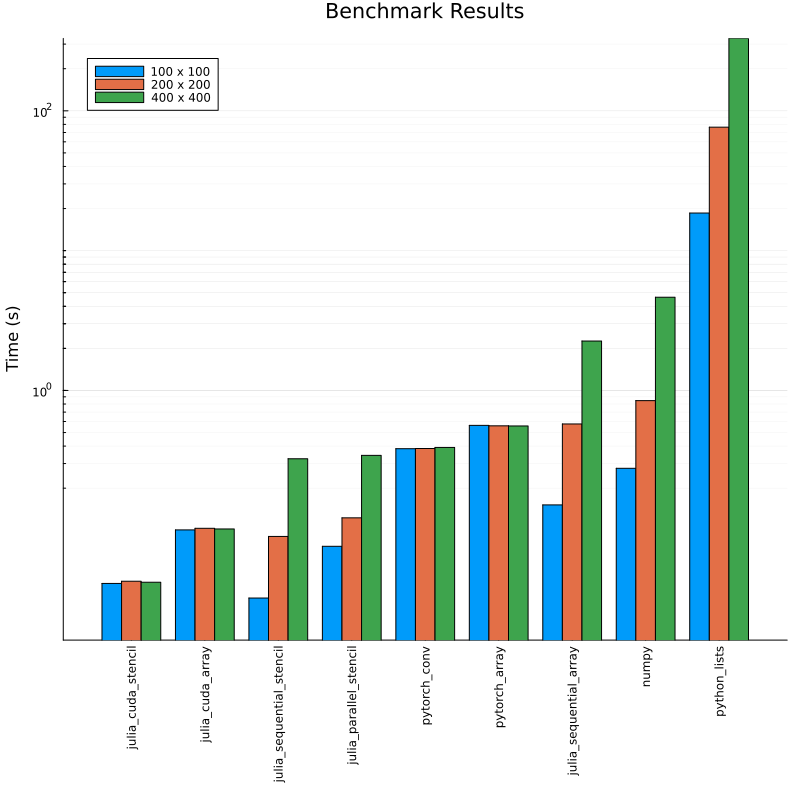

In [38]:
using Plots
using StatsPlots
using YAML
benchmarks = YAML.load_file("benchmark_results.yaml")
num_implementations = length(first(values(benchmarks)))
num_setups = length(keys(benchmarks))
implementation_names = collect(keys(first(values(benchmarks))))
benchmark_names = sort(collect(keys(benchmarks)))
max_time_by_implementation = [maximum([benchmarks[b][i]["time"]["median"] for b in benchmark_names]) for i in implementation_names]
sort_permutation = sortperm(max_time_by_implementation)
implementation_names = collect(implementation_names[sort_permutation])
medians = zeros(num_implementations, num_setups)


for (i, benchmark_name) in enumerate(benchmark_names)
    benchmark = benchmarks[benchmark_name]
    for (j, implementation_name) in enumerate(implementation_names)
        implementation = benchmark[implementation_name]
        time = implementation["time"]["median"]
        medians[j, i] = time
    end
end
min_time = minimum(medians)
max_time= maximum(medians)
benchmark_labels =["$(first(split(b, "."))) x $(first(split(b, ".")))" for b in benchmark_names]

p=groupedbar(medians, yscale=:log10, group=repeat(benchmark_labels, inner=num_implementations),
    xticks=(eachindex(implementation_names), implementation_names), xrotation=90, ylims=(min_time*0.5, max_time), 
    size=(800, 800), yminorgrid=true, xgrid=false, ylabel="Time (s)", title="Benchmark Results")
savefig(p, "benchmark_results.png")
display(p)

In [2]:
repeat(["Category 1", "Category 2"], inner = 5)

10-element Vector{String}:
 "Category 1"
 "Category 1"
 "Category 1"
 "Category 1"
 "Category 1"
 "Category 2"
 "Category 2"
 "Category 2"
 "Category 2"
 "Category 2"